In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()
xtrain, xtest = (x[:,:,:,np.newaxis]/255 for x in (xtrain, xtest))

In [3]:
X = X_input = keras.layers.Input((28,28,1))
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform')(X)
X = keras.layers.Dense(10, activation='softmax')(X)
M = keras.Model(X_input, X)
M.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [4]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=64, epochs=5, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 48us/step - loss: 0.3583 - acc: 0.9013 - val_loss: 0.1955 - val_acc: 0.9420
Epoch 2/5
60000/60000 [==============================] - 2s 40us/step - loss: 0.1708 - acc: 0.9512 - val_loss: 0.1441 - val_acc: 0.9563
Epoch 3/5
60000/60000 [==============================] - 2s 40us/step - loss: 0.1257 - acc: 0.9635 - val_loss: 0.1160 - val_acc: 0.9653
Epoch 4/5
60000/60000 [==============================] - 2s 41us/step - loss: 0.0997 - acc: 0.9709 - val_loss: 0.1095 - val_acc: 0.9673
Epoch 5/5
60000/60000 [==============================] - 2s 40us/step - loss: 0.0840 - acc: 0.9759 - val_loss: 0.1050 - val_acc: 0.9701


In [5]:
@functools.lru_cache()
def get_grad(i):
    print(f'generating grad model of digit {i}')
    X = M(X_input)
    X = %time keras.layers.Lambda( \
        lambda x,i: K.gradients(x[1][:,i], x[0])[0], \
        output_shape=(28,28,1), \
        arguments={'i':i})([X_input, X])
    G = keras.Model(X_input, X)
    G.compile('adam', 'mse')
    return G
@functools.lru_cache()
def get_curv(i):
    print(f'generating curv model of digit {i}')
    X = get_grad(i)(X_input)
    def compute_hessian(x):
        return K.stop_gradient(K.reshape(K.stack([
            K.gradients(x[1][:,iy,ix,:], x[0])[0]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1,28,28,1)))
    def compute_curv(x):
        h = compute_hessian(x)
        return K.stop_gradient(K.reshape(K.stack([
            h[:,iy,ix,:,iy,ix,:]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1)))
    X = %time keras.layers.Lambda( \
        compute_curv, output_shape=(28,28,1))([X_input, X])
    C = keras.Model(X_input, X)
    C.compile('adam', 'mse')
    return C

generating grad model of digit 0
CPU times: user 11.7 ms, sys: 253 µs, total: 12 ms
Wall time: 11.8 ms
generating grad model of digit 1
CPU times: user 11.7 ms, sys: 242 µs, total: 11.9 ms
Wall time: 11.7 ms
generating grad model of digit 2
CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.4 ms
generating grad model of digit 3
CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 11.8 ms
generating grad model of digit 4
CPU times: user 11.8 ms, sys: 251 µs, total: 12.1 ms
Wall time: 12 ms
generating grad model of digit 5
CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 12.7 ms
generating grad model of digit 6
CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 12.4 ms
generating grad model of digit 7
CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 12.1 ms
generating grad model of digit 8
CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 11.8 ms
generating grad model of digit 9
CPU times: user 69.4 ms, sys: 0 ns, to

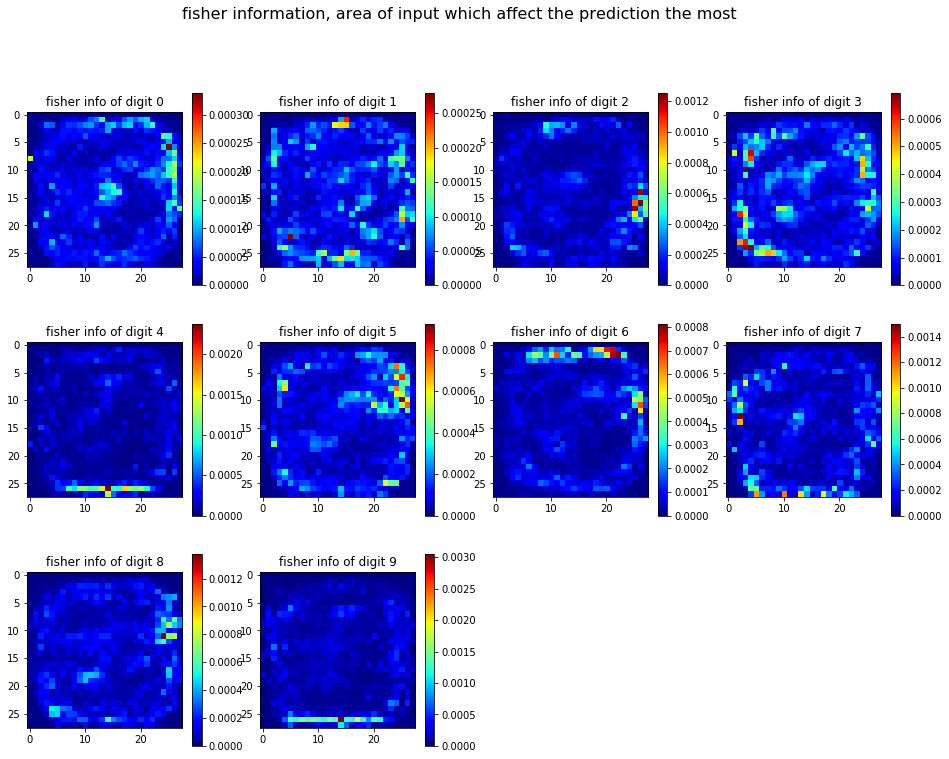

In [6]:
plt.figure(figsize=(16,12))
plt.suptitle('fisher information, area of input which affect the prediction the most', fontsize=16)
vgrads = []
for i in range(10):
    vgrad = get_grad(i).predict(xtest)
    vgrad = np.var(vgrad, axis=0, ddof=1, keepdims=True)
    vgrads.append(vgrad)
    plt.subplot(3,4,i+1)
    plt.title(f'fisher info of digit {i}')
    plt.imshow(vgrad[0,:,:,0], cmap='jet', vmin=0)
    plt.colorbar()
plt.show()

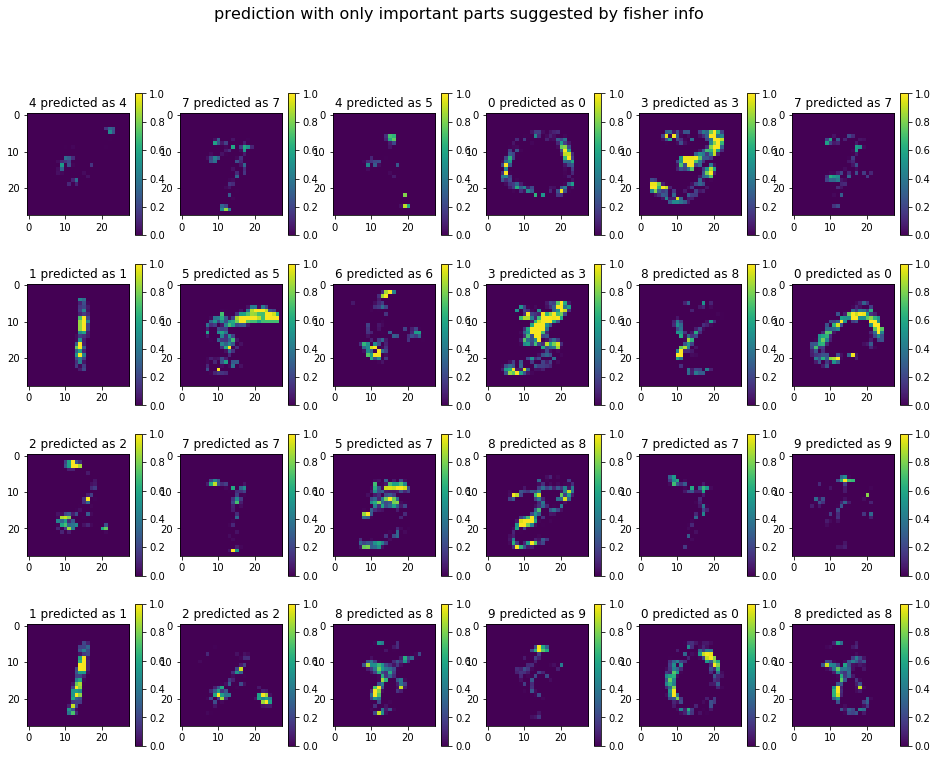

(8, 8)

In [7]:
plt.figure(figsize=(16,12))
plt.suptitle('prediction with only important parts suggested by fisher info', fontsize=16)
for i in range(24):
    fisher_testi = np.random.randint(0, len(xtest))
    fisher_test = xtest[fisher_testi:fisher_testi+1]
    fisher_label = ytest[fisher_testi]
    fisher_test = fisher_test * np.clip(10*(vgrads[fisher_label] / np.max(vgrads[fisher_label])) - 0.5, 0, 1)
    fisher_pred = np.argmax(M.predict(fisher_test)[0])
    plt.subplot(4,6,i+1)
    plt.imshow(fisher_test[0,:,:,0], vmin=0, vmax=1)
    plt.title(f'{fisher_label} predicted as {fisher_pred}')
    plt.colorbar()
plt.show()

In [8]:
def test_plot(test_label, improve_as):
    G,C = get_grad(improve_as), get_curv(improve_as)
    test_idx = np.random.choice(np.where(ytest == test_label)[0])
    test = xtest[test_idx:test_idx+1]
    pred = M.predict(test)
    grad = G.predict(test)
    curv = C.predict(test)
    digit = np.argmax(pred[0])
    plt.figure(figsize=(16,4))
    plt.suptitle(f'labeled as {test_label}, predicted as {digit} ({pred[0,digit]:.4f}), improve to be {improve_as}', fontsize=16)
    plt.subplot(1,4,1)
    plt.title('input')
    plt.imshow(test[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.title('gradients')
    plt.imshow(grad[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.title('curvatures')
    plt.imshow(curv[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.title('abs(curvatures)')
    plt.imshow(abs(curv[0,:,:,0]), cmap='jet', vmin=0)
    plt.colorbar()
    plt.show()

generating curv model of digit 8
CPU times: user 1min 18s, sys: 629 ms, total: 1min 18s
Wall time: 1min 18s


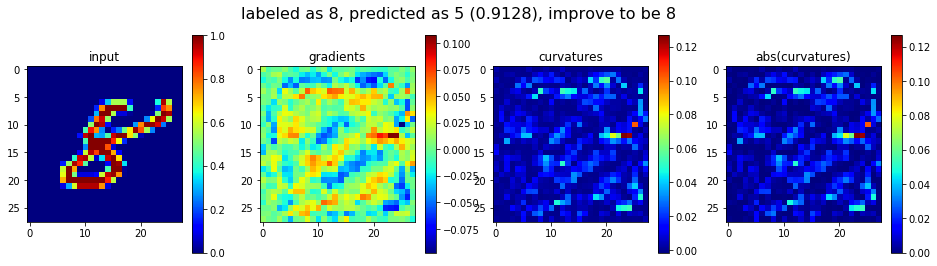

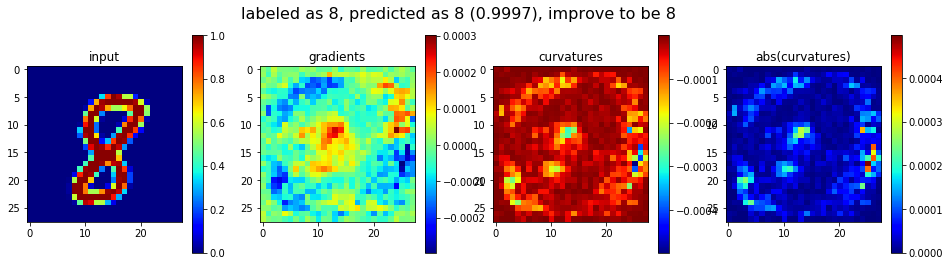

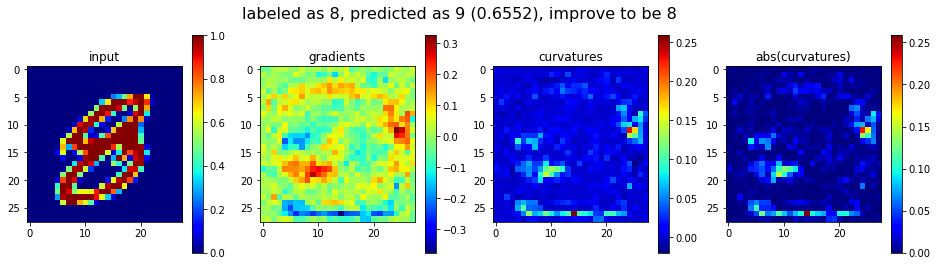

In [9]:
for _ in range(3):
    test_plot(8, 8)

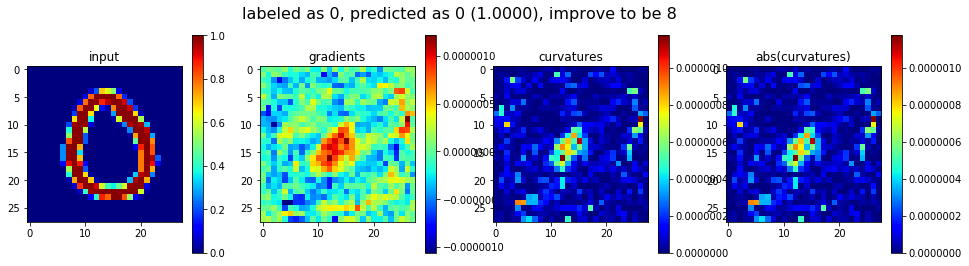

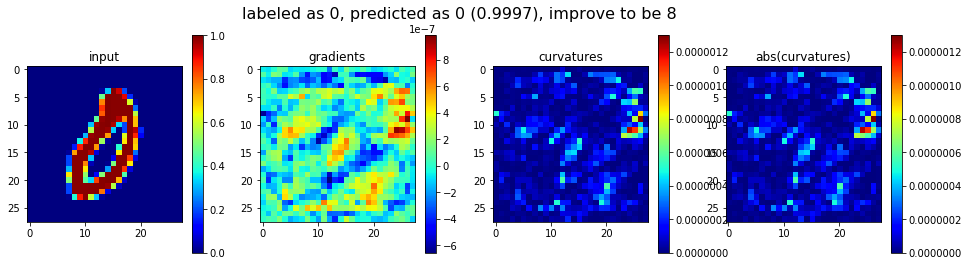

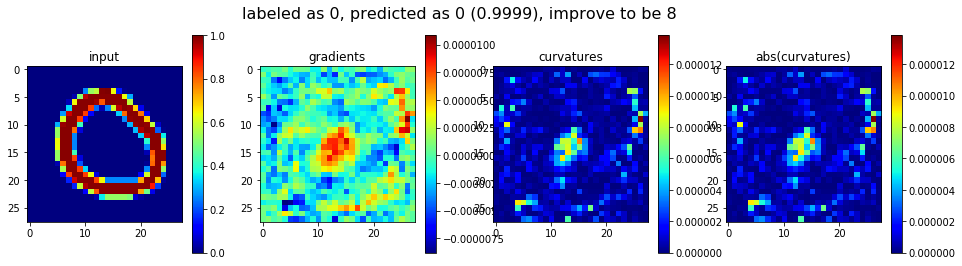

In [10]:
for _ in range(3):
    test_plot(0, 8)

generating curv model of digit 2
CPU times: user 2min 58s, sys: 927 ms, total: 2min 59s
Wall time: 2min 58s


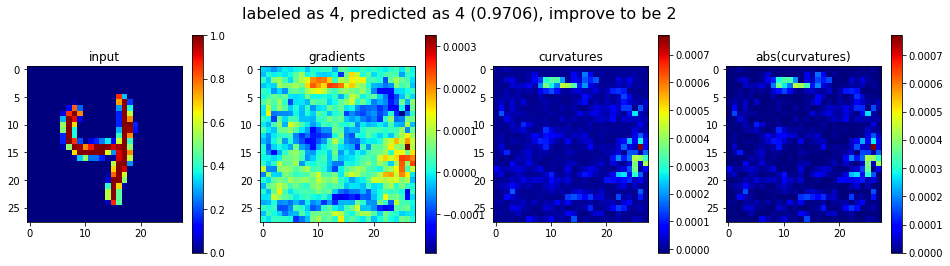

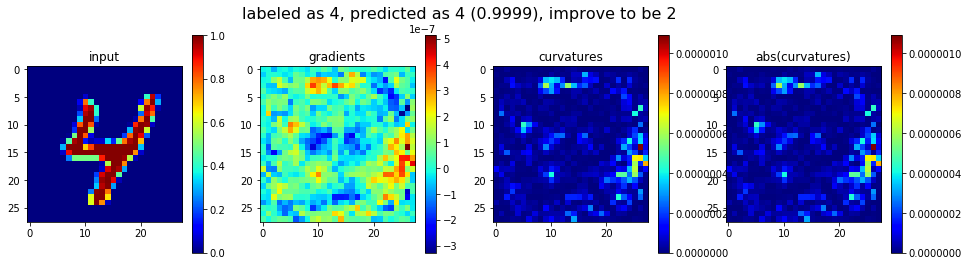

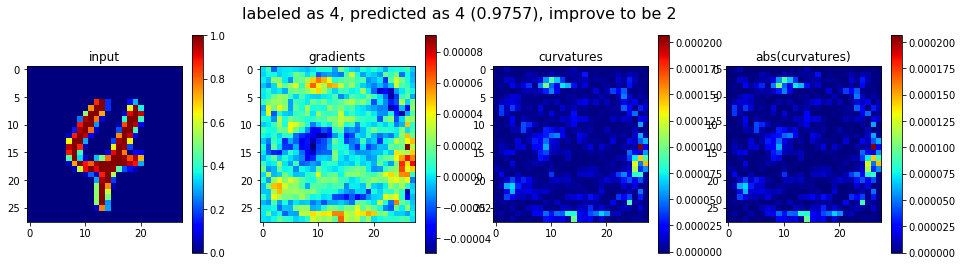

In [11]:
for _ in range(3):
    test_plot(4, 2)